<a href="https://colab.research.google.com/github/krishnanravi03/convolution-nueral-networks/blob/main/Inception_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import copy
from sklearn.metrics import classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Model definition

In [11]:
def Conv2dLayer(in_channels, out_channels, kernel_size, **kwargs):
  return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU()
        )

class InceptionModule(nn.Module):
    def __init__(self, in_channels, filers_1x1, filters_3x3_reduce, filers_3x3, filters_5x5_reduce, filters_5x5, filters_pool_projection):
        super(InceptionModule, self).__init__()
        self.conv1x1 = Conv2dLayer(in_channels, filers_1x1, kernel_size=1)
        self.conv3x3_reduce = Conv2dLayer(in_channels, filters_3x3_reduce, kernel_size=1)  
        self.conv3x3 = Conv2dLayer(filters_3x3_reduce, filers_3x3, kernel_size=3, padding=1)
        self.conv5x5_reduce = Conv2dLayer(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv5x5 = Conv2dLayer(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_projection = Conv2dLayer(in_channels, filters_pool_projection, kernel_size=1)
         
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_reduce(x)
        x2 = self.conv3x3(x2)
        x3 = self.conv5x5_reduce(x)
        x3 = self.conv5x5(x3)
        x4 = self.maxpool(x)
        x4 = self.pool_projection(x4)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, filers_1x1, filters_3x3_reduce, filers_3x3, filters_5x5_reduce, filters_5x5, filters_pool_projection):
        super(InceptionModule, self).__init__()
        self.conv1x1 = Conv2dLayer(in_channels, filers_1x1, kernel_size=1)
        self.conv3x3_reduce = Conv2dLayer(in_channels, filters_3x3_reduce, kernel_size=1)  
        self.conv3x3 = Conv2dLayer(filters_3x3_reduce, filers_3x3, kernel_size=3, padding=1)
        self.conv5x5_reduce = Conv2dLayer(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv5x5 = Conv2dLayer(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_projection = Conv2dLayer(in_channels, filters_pool_projection, kernel_size=1)
         
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_reduce(x)
        x2 = self.conv3x3(x2)
        x3 = self.conv5x5_reduce(x)
        x3 = self.conv5x5(x3)
        x4 = self.maxpool(x)
        x4 = self.pool_projection(x4)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, output_classes):
        super(Inception, self).__init__()
        self.convLayer1 = Conv2dLayer(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.convlayer2 = Conv2dLayer(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, output_classes)

        self.inceptionLayer3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inceptionLayer3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inceptionLayer4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inceptionLayer4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inceptionLayer4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inceptionLayer4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inceptionLayer4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inceptionLayer5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inceptionLayer5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.maxpool(x)
        x = self.convlayer2(x)
        x = self.maxpool(x)
        x = self.inceptionLayer3a(x)
        x = self.inceptionLayer3b(x)
        x = self.maxpool(x)
        x = self.inceptionLayer4a(x)
        x = self.inceptionLayer4b(x)
        x = self.inceptionLayer4c(x)
        x = self.inceptionLayer4d(x)
        x = self.inceptionLayer4e(x)
        x = self.maxpool(x)
        x = self.inceptionLayer5a(x)
        x = self.inceptionLayer5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.linear(x)      
        return x

Training Function

In [12]:
def train_model(model, dataloaders, num_of_epochs=5, lr=0.0001):
  start_time = time.time()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
  training_losses = []
  validation_losses = []
  training_accuracies = []
  validation_accuracies = []
  best_model_so_far = copy.deepcopy(model.state_dict())
  best_accuracy_so_far = 0.0
  phases = ['train', 'validation']

  for epoch in range(num_of_epochs):
    for phase in phases:
      if phase == 'train':
          model.train()
      else:
          model.eval()
      loss_so_far = 0.0
      correct_predictions_so_far = 0
      for inputs, labels in dataloaders[phase]:          
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            if phase == 'train':
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()
            if phase == 'validation':
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)

        loss_so_far += loss.item() * inputs.size(0)
        correct_predictions_so_far += torch.sum(predictions == labels.data)

      loss_for_epoch = loss_so_far / len(dataloaders[phase].dataset)
      if phase == 'validation': 
          lr_scheduler.step(loss_for_epoch)
      accuracy_for_epoch = correct_predictions_so_far.double() / len(dataloaders[phase].dataset)


      print('Epoch {}/{}'.format(epoch, num_of_epochs - 1))
      print('-----------------------')
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, loss_for_epoch, accuracy_for_epoch))

      if phase == 'validation' and accuracy_for_epoch > best_accuracy_so_far:
        best_accuracy_so_far = accuracy_for_epoch
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'validation':
        validation_accuracies.append(accuracy_for_epoch.item())
        validation_losses.append(loss_for_epoch)
      if phase == 'train':
        training_accuracies.append(accuracy_for_epoch.item())
        training_losses.append(loss_for_epoch)
      print()

  time_taken = time.time() - start_time
  print('Time taken for training {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
  model.load_state_dict(best_model_so_far)
  return model, training_losses, training_accuracies, validation_losses, validation_accuracies

Testing Function

In [13]:
def test_model(model, test_loader):
  with torch.no_grad():
    correct_predictions = 0
    no_of_samples = 0
    for indx, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      input_labels = labels.to(device)
      outputs= model(inputs)
      _, predictions = torch.max(outputs, 1)
      correct_predictions += (predictions == input_labels).sum().item()
      no_of_samples += input_labels[0]
  return classification_report(input_labels, predictions)

In [19]:
def getDataLoaders(train_dataset, test_dataset, batch_size, train_split_ratio=0.8):
  train_size = int(len(train_dataset) * train_split_ratio)
  validation_size = len(train_dataset) - train_size
  train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
  return train_loader, validation_loader, test_loader

def plot_values(input_y, input_x, x_label, y_label, title, x_ticks):
  for values in input:
    plt.plot(input_x, values)
  plt.xticks(x_ticks)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

def get_new_model(in_channels, no_of_labels):
  model = Inception(in_channels=in_channels, output_classes=no_of_labels)
  return model

def visualize_data(data_loader):
  value = iter(data_loader)
  value_data, value_label = next(value)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(value_data[i][0], cmap='gray')
  plt.show()


MNIST Dataset

In [23]:
mnist_data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
mnist_train_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=mnist_data_transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root='./data',train=False,transform=mnist_data_transform, download=True)
mnist_train_loader, mnist_validation_loader, mnist_test_loader = getDataLoaders(mnist_train_dataset, mnist_test_dataset, batch_size=20)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


MNIST - Visualization

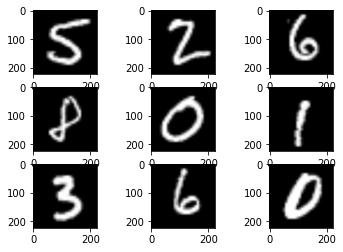

In [24]:
visualize_data(mnist_train_loader)

In [ ]:
mnist_model = get_new_model(1, 10)
mnist_model.to(device)
data_loaders = {"train": mnist_train_loader, "validation": mnist_validation_loader}
mnist_model, training_losses_mnist, training_accuracies_mnist, validation_losses_mnist, validation_accuracies_mnist = train_model(mnist_model, data_loaders, num_of_epochs=1)